In [23]:
# SecureString parameter stored in AWS System Manager that holds a GitHub personal access token.
parameter_name = 'github_token'

# Repositories for which reports will be generated.
repo_names = ['aws-amplify/amplify-android', 'aws-amplify/aws-sdk-android']

# Labels used across different repositories
issue_buckets = {'Bug': ['Bug'],
                 'Feature Request': ['Improvement', 'Feature Request'],
                 'Question': ['Usage Question'],
                 'Pending Triage': ['Pending Triage']}

In [24]:
# Retrieve the GitHub token from SSM to prevent oops-I-pushed-credentials-to-GitHub uh-ohs.

import boto3

ssm = boto3.client('ssm')
response = ssm.get_parameter(Name=parameter_name, WithDecryption=True)
token = response['Parameter']['Value']

In [25]:
# Grab all issues from the GitHub V4 GraphQL API

import requests
import json

headers = {'Authorization': f'Bearer {token}'}

def get_issues(owner, name, *, end_cursor=None):
    query = """
    query($owner: String!, $name: String!, $endCursor: String) {
      repository(owner:$owner, name:$name) {
        issues(first:100, after:$endCursor) {
          nodes {
            number
            title
            createdAt
            closedAt
            reactions {
              totalCount
            }
            comments(first:100) {
              nodes {
                createdAt
                author {
                  login
                }
                reactions {
                  totalCount
                }
              }
            }
            labels(first:3) {
              nodes {
                name
              }
            }
          }
          pageInfo {
            hasNextPage
            endCursor
          }
        }
      }
    }"""
    
    variables = {'owner': owner, 'name': name, 'endCursor': end_cursor}
    response = execute(query, variables)
    page_info = response['data']['repository']['issues']['pageInfo']
    nodes = response['data']['repository']['issues']['nodes']
    
    for issue in nodes:
        yield issue
    
    if page_info['hasNextPage']:
        yield from get_issues(owner, name, end_cursor=page_info['endCursor'])
    
def execute(query, variables):
    request = requests.post('https://api.github.com/graphql', json={'query': query, 'variables': variables},
                                                              headers=headers)

    if request.status_code == 200:
        return request.json()
    else:
        raise Exception("{}: {}".format(request.status_code, query))

In [32]:
# Loop through each repository, grab all issues, and create a DataFrame for each.

import pandas as pd

repos = {}
bucket_lookup = {label: bucket for bucket, labels in issue_buckets.items() for label in labels}

for repo_name in repo_names:
    issues = []
    owner, name = repo_name.split('/')

    for issue in get_issues(owner, name):
        labels = pd.array([label['name'] for label in issue['labels']['nodes']])
        bucket = 'Other'
        created_at = pd.Timestamp(issue['createdAt'],tz='UTC')
        
        score = 1
        score += len(issue['comments']) 
        score += issue['reactions']['totalCount']
        score += sum(comment['reactions']['totalCount'] for comment in issue['comments']['nodes'])
        
        if issue['closedAt']:
            closed_at = pd.Timestamp(issue['closedAt'], tz='UTC')
        else:
            closed_at = None
            
        for label in labels:
            if label in bucket_lookup:
                bucket = label
                break
                
        issues.append([issue['number'], issue['title'], labels, created_at, closed_at, bucket, score])
        
    repos[repo_name] = pd.DataFrame(issues, columns=['id', 'title', 'labels', 'created_at', 'closed_at', 'bucket', 'score'])

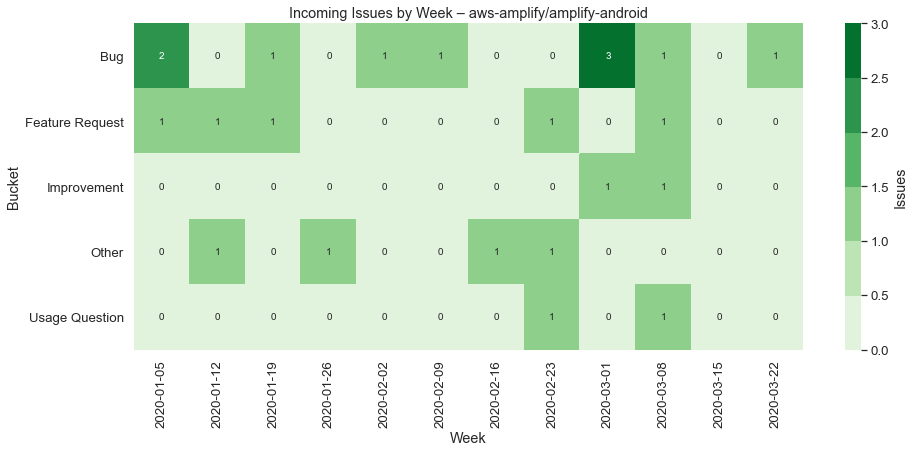

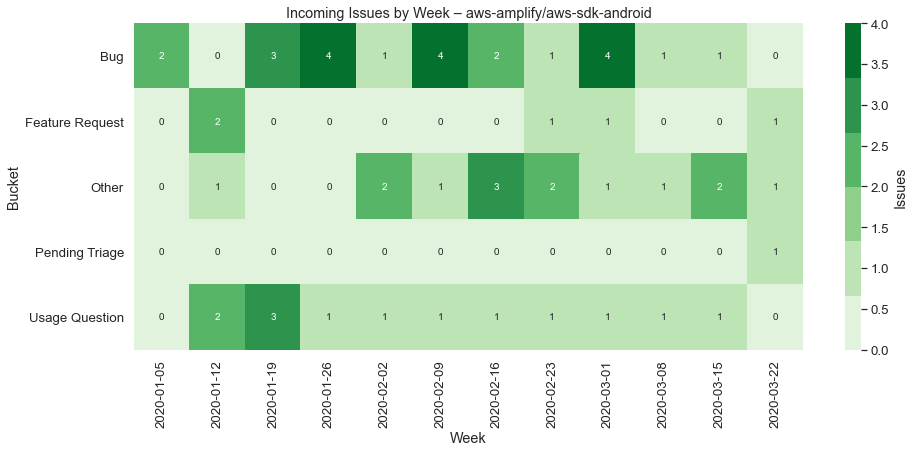

In [33]:
from IPython.core.display import HTML
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import seaborn as sns
import pytz

now = datetime.utcnow().replace(tzinfo=pytz.utc)
idx = pd.date_range(now - timedelta(weeks=12), now, freq='W')   

sns.set(font_scale=1.2)

%matplotlib inline

for repo_name, df in repos.items():
    plt.subplots(figsize=(15, 6))
    
    df = df.loc[df.created_at > now - timedelta(weeks=12)] 
    df = df.pivot(index='created_at', columns='bucket', values='created_at')
    df = pd.concat([df, pd.DataFrame(index=[date for date in idx])])    
    df = df.resample('W', label='left').count().transpose()
    dates = df.columns.strftime('%Y-%m-%d').sort_values().unique()

    ax = sns.heatmap(df, xticklabels=dates, cmap=sns.color_palette("Greens"), fmt='d', annot=True,
                     cbar_kws={'label': 'Issues'})
    ax.set(xlabel='Week', ylabel='Bucket', title=f'Incoming Issues by Week – {repo_name}')

    plt.show()

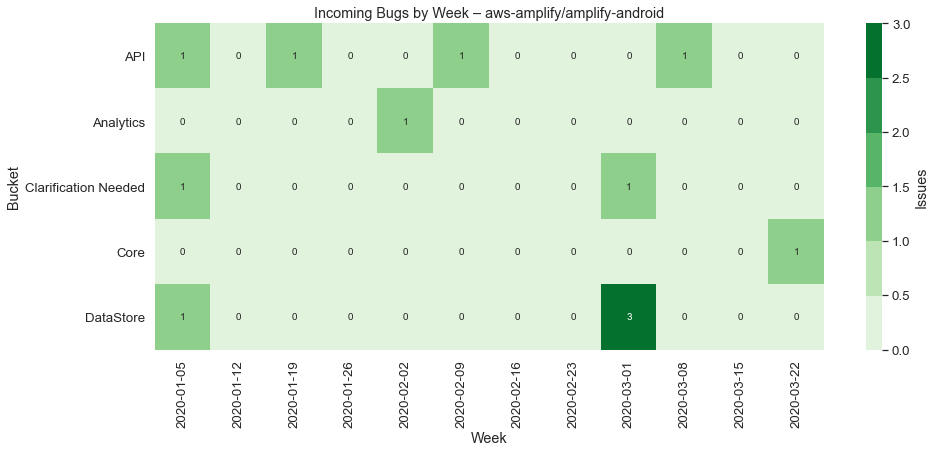

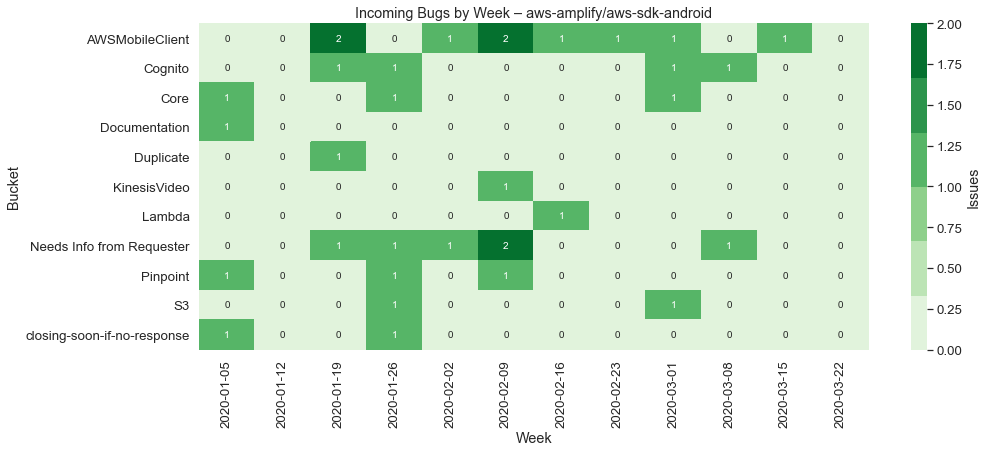

In [34]:
# Incoming Bugs by Week

from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pytz

now = datetime.utcnow().replace(tzinfo=pytz.utc)
idx = pd.date_range(now - timedelta(weeks=12), now, freq='W')   

sns.set(font_scale=1.2)

%matplotlib inline

for repo_name, df in repos.items():
    plt.subplots(figsize=(15, 6))
        
    df = df.loc[df.created_at > now - timedelta(weeks=12)] 
    df = df.loc[np.array(list(map(len, df.labels.values))) > 0]
    df = df.labels.apply(pd.Series).merge(df, left_index = True, right_index = True)
    df = df.drop(["labels"], axis = 1)
    df = df.melt(id_vars = ['id', 'title', 'bucket', 'created_at', 'closed_at', 'score'], value_name = 'label')
    df = df.dropna(subset=['label'])
    df = df.loc[df.label.apply(lambda l: l not in issue_buckets.keys())]
    df = df.loc[df.bucket == 'Bug']
    df = df.pivot(index='created_at', columns='label', values='created_at')
    df = pd.concat([df, pd.DataFrame(index=[date for date in idx])])    
    df = df.resample('W', label='left').count().transpose()

    dates = df.columns.strftime('%Y-%m-%d').sort_values().unique()
    ax = sns.heatmap(df, xticklabels=dates, cmap=sns.color_palette("Greens"), fmt='d', annot=True,
                     cbar_kws={'label': 'Issues'})
    ax.set(xlabel='Week', ylabel='Bucket', title=f'Incoming Bugs by Week – {repo_name}')

    plt.show()

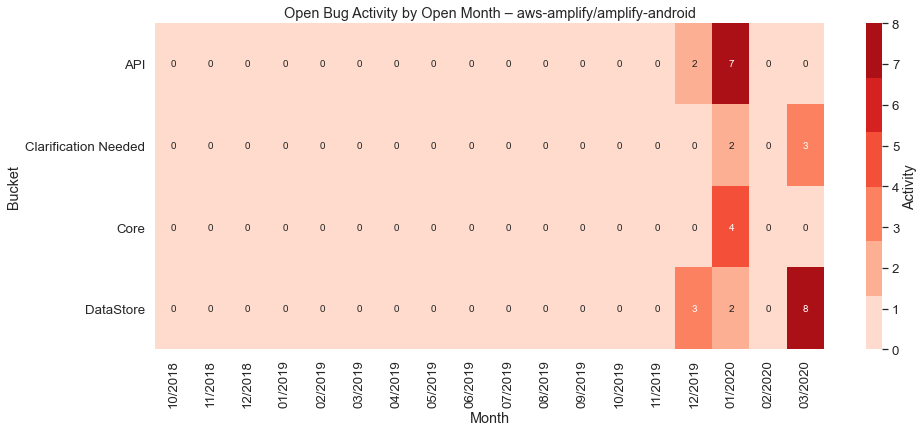

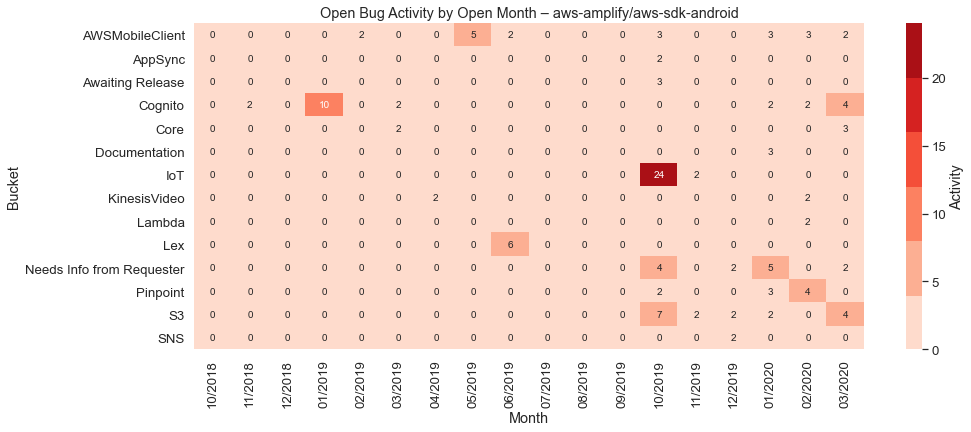

In [35]:
# Open Bug Activity by Open Week

from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pytz

now = datetime.utcnow().replace(tzinfo=pytz.utc)
idx = pd.date_range(now - timedelta(weeks=78), now, freq='W')   

sns.set(font_scale=1.2)

%matplotlib inline

for repo_name, df in repos.items():
    plt.subplots(figsize=(15, 6))
        
    df = df.loc[df.created_at > now - timedelta(weeks=78)]
    df = df[~(df.closed_at > '1970-01-01')]
    df = df.loc[np.array(list(map(len, df.labels.values))) > 0]
    df = df.labels.apply(pd.Series).merge(df, left_index = True, right_index = True)
    df = df.drop(["labels"], axis = 1)
    df = df.melt(id_vars = ['id', 'title', 'bucket', 'created_at', 'closed_at', 'score'], value_name = 'label')
    df = df.dropna(subset=['label'])
    df = df.loc[df.label.apply(lambda l: l not in issue_buckets.keys())]
    df = df.loc[df.bucket == 'Bug']
    df = df.pivot(index='created_at', columns='label', values='score')
    df = pd.concat([df, pd.DataFrame(index=[date for date in idx])])    
    df = df.resample('M', label='right').sum().transpose()

    dates = df.columns.strftime('%m/%Y')
    ax = sns.heatmap(df, xticklabels=dates, cmap=sns.color_palette("Reds"), annot=True,
                     cbar_kws={'label': 'Activity'})
    ax.set(xlabel='Month', ylabel='Bucket', title=f'Open Bug Activity by Open Month – {repo_name}')

    plt.show()

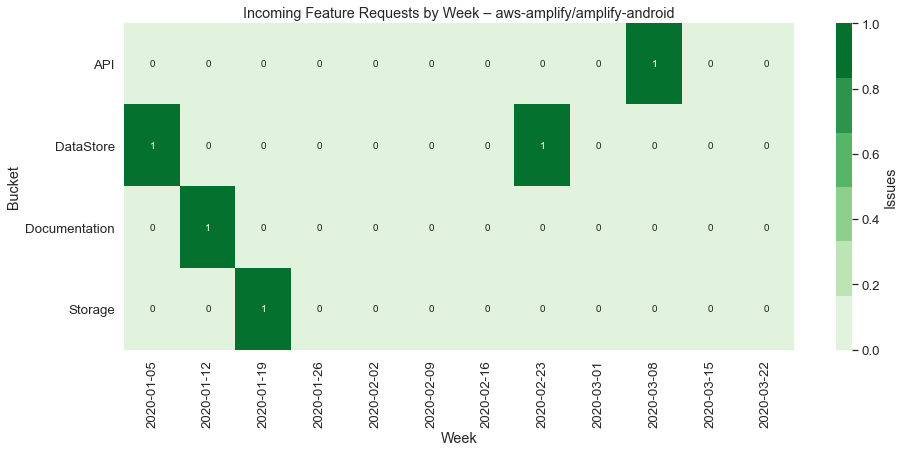

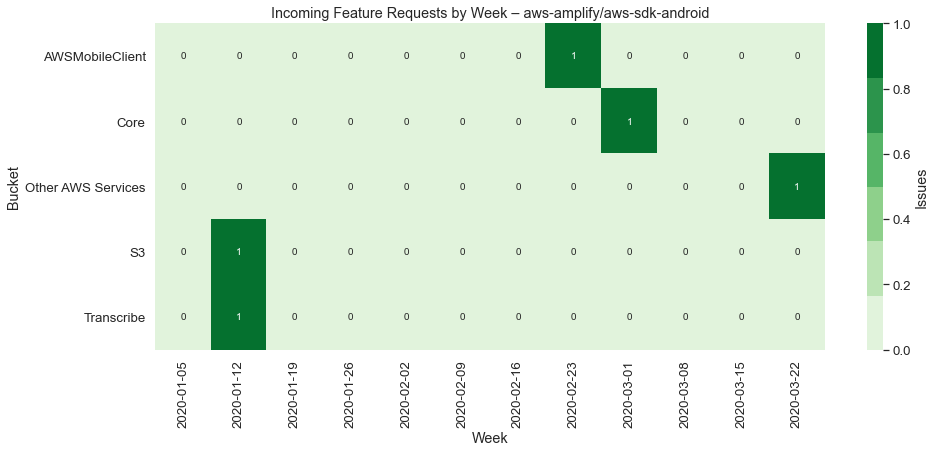

In [36]:
# Incoming Feature Requests by Week

from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pytz

now = datetime.utcnow().replace(tzinfo=pytz.utc)
idx = pd.date_range(now - timedelta(weeks=12), now, freq='W')   

sns.set(font_scale=1.2)

%matplotlib inline

for repo_name, df in repos.items():
    plt.subplots(figsize=(15, 6))
    
    df = df.loc[df.created_at > now - timedelta(weeks=12)] 
    df = df.loc[np.array(list(map(len, df.labels.values))) > 0]
    df = df.labels.apply(pd.Series).merge(df, left_index = True, right_index = True)
    df = df.drop(["labels"], axis = 1)
    df = df.melt(id_vars = ['id', 'title', 'bucket', 'created_at', 'closed_at', 'score'], value_name = 'label')
    df = df.dropna(subset=['label'])
    df = df.loc[df.label.apply(lambda l: l not in issue_buckets.keys())]
    df = df.loc[df.bucket == 'Feature Request']
    df = df.pivot(index='created_at', columns='label', values='created_at')
    df = pd.concat([df, pd.DataFrame(index=[date for date in idx])])    
    df = df.resample('W', label='left').count().transpose()
    
    dates = df.columns.strftime('%Y-%m-%d').sort_values().unique()
    ax = sns.heatmap(df, xticklabels=dates, cmap=sns.color_palette("Greens"), fmt='d', annot=True,
                     cbar_kws={'label': 'Issues'})
    ax.set(xlabel='Week', ylabel='Bucket', title=f'Incoming Feature Requests by Week – {repo_name}')

    plt.show()

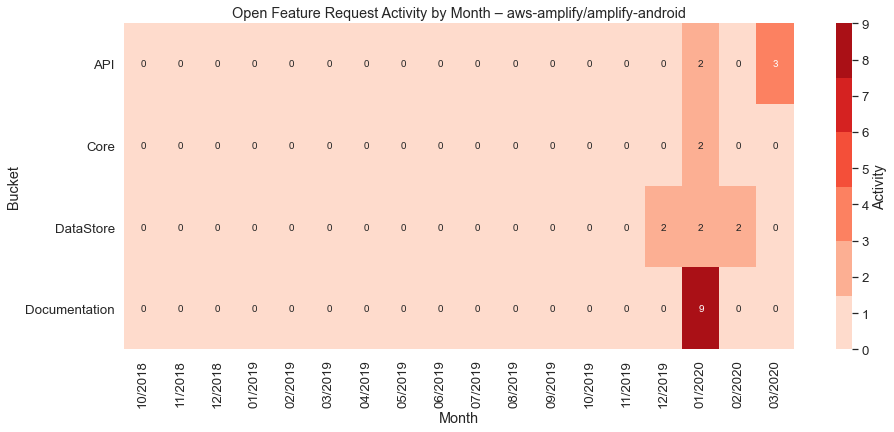

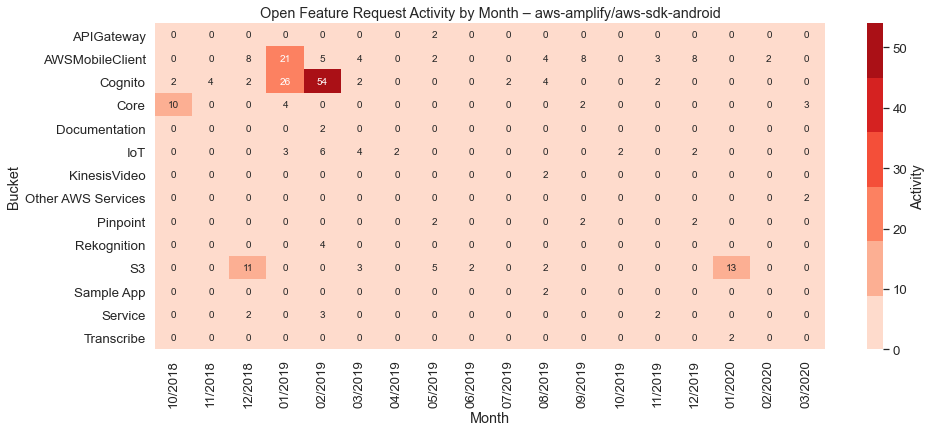

In [37]:
# Incoming Feature Request Activity by Open Week

from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pytz

now = datetime.utcnow().replace(tzinfo=pytz.utc)
idx = pd.date_range(now - timedelta(weeks=78), now, freq='W')   

sns.set(font_scale=1.2)

%matplotlib inline

for repo_name, df in repos.items():
    plt.subplots(figsize=(15, 6))

    
    df = df.loc[df.created_at > now - timedelta(weeks=78)] 
    df = df[~(df.closed_at > '1970-01-01')]
    df = df.loc[np.array(list(map(len, df.labels.values))) > 0]
    df = df.labels.apply(pd.Series).merge(df, left_index = True, right_index = True)
    df = df.drop(["labels"], axis = 1)
    df = df.melt(id_vars = ['id', 'title', 'bucket', 'created_at', 'closed_at', 'score'], value_name = 'label')
    df = df.dropna(subset=['label'])
    df = df.loc[df.label.apply(lambda l: l not in issue_buckets.keys())]
    df = df.loc[df.bucket == 'Feature Request']
    df = df.pivot(index='created_at', columns='label', values='score')
    df = pd.concat([df, pd.DataFrame(index=[date for date in idx])])    
    df = df.resample('M', label='right').sum().transpose()
    
    dates = df.columns.strftime('%m/%Y')
    ax = sns.heatmap(df, xticklabels=dates, cmap=sns.color_palette("Reds"), annot=True,
                     cbar_kws={'label': 'Activity'})
    ax.set(xlabel='Month', ylabel='Bucket', title=f'Open Feature Request Activity by Month – {repo_name}')
    plt.yticks(rotation=0)

    plt.show()

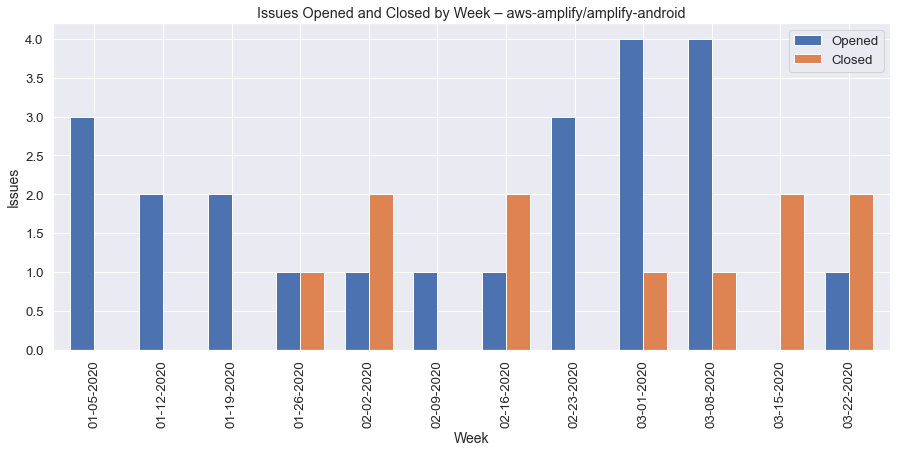

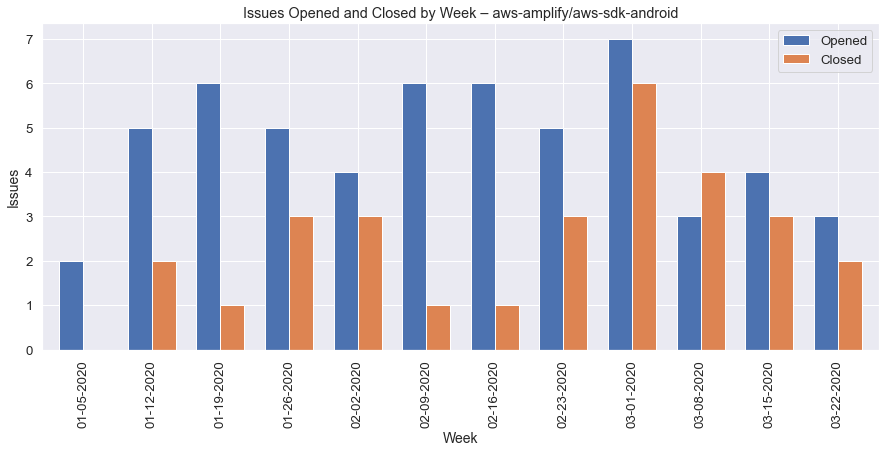

In [38]:
# Issues Opened and Closed by Week

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import pytz

now = datetime.utcnow().replace(tzinfo=pytz.utc)

%matplotlib inline

for repo_name, df in repos.items():
    df = df.loc[df.created_at > now - timedelta(weeks=12)] 
    opened = df.set_index('created_at')
    opened = opened.id.resample('W', label='left').count().transpose().to_frame('count')
    closed = df.dropna().set_index('closed_at').sort_values(by='closed_at')
    closed = closed.id.resample('W', label='left').count().transpose().to_frame('count')

    both = opened.join(closed, how='left', lsuffix='_opened', rsuffix='_closed')
    both.index = both.index.rename('date')
    both = both.rename(columns={'count_opened': 'Opened', 'count_closed': 'Closed'})
    ax = both[['Opened','Closed']].plot(kind='bar', width=0.7, figsize=(15, 6), legend=True)

    ax.set_xlabel('Week', fontsize=14)
    ax.set_ylabel('Issues', fontsize=14)
    ax.set_xticklabels(both.index.strftime('%m-%d-%Y'))
    ax.set(title=f'Issues Opened and Closed by Week – {repo_name}')
    
    plt.show()

In [39]:
# Top Bugs by Activity

display(HTML(f'<h1>Top Bugs by Activity</h1>'))

for repo_name, df in repos.items():
    df = df.loc[df.bucket == 'Bug']
    df = df.sort_values(axis=0, by=['score'], ascending=False)

    display(HTML(f'<h2>{repo_name}</h2>'))
    display(df[['id', 'title', 'created_at', 'labels', 'score']].head(20))

,id,title,created_at,labels,score
24,211,Initialization in Activity#onCreate() may caus...,2020-01-02 21:23:34+00:00,"[Bug, Core]",4
52,319,Amplify import error after 'modelgen' gradle task,2020-03-23 15:14:48+00:00,"[Bug, Core]",3
21,203,Amplify.API.mutate error: Java.Lang.NoSuchMeth...,2019-12-20 03:42:45+00:00,"[API, Bug]",3
22,209,[DataStore] Freeze on startup,2019-12-30 15:22:51+00:00,"[Bug, DataStore]",3
29,216,GsonVariablesSerializer should support ISO 860...,2020-01-02 22:13:34+00:00,"[API, Bug]",3
46,295,Problems with datastore,2020-03-04 15:42:37+00:00,"[Bug, Clarification Needed, DataStore]",3
44,293,DataStore SyncEngine to remain active even whi...,2020-03-03 20:09:48+00:00,"[Bug, DataStore]",3
39,264,[API] query with predicate behaves strangely,2020-02-14 23:08:29+00:00,"[API, Bug]",2
51,304,Amplify.Api.Get fails when attempting to pass ...,2020-03-15 19:32:42+00:00,"[API, Bug]",2
45,294,Sync Engine will try to publish a change twice...,2020-03-03 20:15:27+00:00,"[Bug, DataStore]",2


,id,title,created_at,labels,score
667,937,Error in retrieving the encryption key used fo...,2019-05-03 00:31:07+00:00,"[Bug, Core, Needs Info from Requester]",23
801,1259,AWSIotMqttManager NoClassDefFoundError with An...,2019-10-16 19:36:15+00:00,"[Bug, IoT]",20
349,400,Using startService for a background event is c...,2018-01-23 12:11:22+00:00,"[Bug, S3]",16
646,888,Authentication by Cognito Hosted UI can not ge...,2019-04-09 05:17:10+00:00,"[AWSMobileClient, Bug, Needs Info from Requester]",13
504,584,AWSIotMqttManager no longer able to reconnect,2018-11-20 12:55:44+00:00,"[Bug, IoT, Needs Info from Requester]",12
290,328,"cognitoauth: Erroneous ""user cancelled"" AuthNa...",2017-08-11 04:02:00+00:00,"[Bug, Cognito, Needs Info from Requester]",11
345,394,AWS IOT Reconnecting Issue,2018-01-09 07:10:11+00:00,"[Bug, IoT, Needs Info from Requester]",10
650,899,S3 upload hangs up in WAITING_FOR_NETWORK state,2019-04-15 19:44:57+00:00,"[Awaiting Release, Bug, S3]",9
567,679,Refresh token expired earlier than it should o...,2019-01-29 15:32:35+00:00,"[Bug, Cognito]",8
670,942,Cognito - Sign In - Error in federating the token,2019-05-07 17:51:42+00:00,"[AWSMobileClient, Bug, Needs Info from Requester]",8


In [40]:
# Top Feature Requests by Activity

display(HTML(f'<h1>Top Feature Requests by Activity</h1>'))

for repo_name, df in repos.items():
    df = df.loc[df.bucket == 'Feature Request']
    df = df.sort_values(axis=0, by=['score'], ascending=False)

    display(HTML(f'<h2>{repo_name}</h2>'))
    display(df[['id', 'title', 'created_at', 'labels', 'score']].head(20))

,id,title,created_at,labels,score
34,237,Add documentation for Kotlin,2020-01-14 06:22:51+00:00,"[Documentation, Feature Request]",9
35,240,No option to get the URL of item in S3 bucket ...,2020-01-20 10:05:16+00:00,"[Feature Request, Storage]",9
50,303,Using Custom GraphQL Endpoint,2020-03-13 08:49:34+00:00,"[API, Feature Request]",3
1,19,Distribution infrastructure,2019-10-09 17:26:53+00:00,"[Feature Request, Infrastructure]",2
2,21,CI/CD Infrastructure,2019-10-09 22:26:04+00:00,"[Duplicate, Feature Request, Infrastructure]",2
3,39,[API/AppSync] Structure AuthorizationDetails,2019-10-23 18:58:18+00:00,"[API, Clarification Needed, Feature Request]",2
4,45,[API] Investigate default implementation for O...,2019-10-31 22:49:13+00:00,"[API, Feature Request]",2
10,79,[Predicates] Predicate design,2019-11-18 20:27:42+00:00,"[API, DataStore, Feature Request]",2
14,169,Fix IAM auth in REST API,2019-12-04 17:03:02+00:00,"[API, Feature Request]",2
20,195,When we will have unity SDK ?,2019-12-12 05:21:55+00:00,"[DataStore, Feature Request]",2


,id,title,created_at,labels,score
572,684,Custom scopes in access token programmatically,2019-02-02 19:28:41+00:00,"[Cognito, Feature Request]",47
412,471,AWS Auth compatibility for API 22 and lower,2018-05-29 23:06:45+00:00,"[Cognito, Feature Request]",33
355,407,Instantiate the AWSMobileClient from non-Activ...,2018-02-08 19:34:57+00:00,"[AWSMobileClient, Feature Request, Needs Info ...",19
539,634,RFC - Auth workflows: improvements and additions,2019-01-04 00:51:33+00:00,"[AWSMobileClient, Cognito, Feature Request]",19
227,260,No public method to know if a user is logged in,2017-03-01 13:44:24+00:00,"[Cognito, Feature Request, Needs Info from Req...",17
442,505,Upload multiple files using TransferUtility,2018-08-04 17:50:33+00:00,"[Feature Request, S3]",15
859,1436,TransferUtility upload - Support InputStream a...,2020-01-17 00:06:38+00:00,"[Feature Request, S3]",13
476,547,Add Secrets Manager to Android and iOS SDKs,2018-10-16 19:30:45+00:00,"[Core, Feature Request]",10
395,450,Using Pinpoint for event-driven user-specific ...,2018-04-24 19:56:09+00:00,"[Feature Request, Pinpoint]",8
525,616,Adapt S3 TransferUtility for unstable network ...,2018-12-13 23:39:49+00:00,"[Feature Request, S3]",7
